# Text detection

### Libraries

In [1]:
from pdf2image import convert_from_path

import boto3
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os

### Functions

In [2]:
BOUNDING_BOX_KEYS = ['Width', 'Height', 'Left', 'Top']

In [3]:
def select_random_sample_from_list(l):
    n = len(l)
    index = np.random.randint(n)
    return l[index]

In [4]:
def draw_bounding_box(img, bounding_box, text=''):
    width = img.shape[1]
    height = img.shape[0]
    w, h = int(bounding_box[0]*width), int(bounding_box[1]*height)
    x, y = int(bounding_box[2]*width), int(bounding_box[3]*height)
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 3)
    cv2.putText(img, text, (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    return img

In [5]:
def convert_img_to_bytes(file):
    with open(file, 'rb') as f:
        source_bytes = f.read()
    return source_bytes

In [39]:
def get_relationship_type_ids(ids, relationships):
    relationships_type = []
    relationships_ids = []
    for relationship in relationships:
        try:
            relationship = relationship[0]
            relationships_type.append(relationship['Type'])
            relationships_ids.append(
                [ids[ids == id_].index[0] for id_ in relationship['Ids']]
            )            
        except:
            relationships_type.append(None)
            relationships_ids.append(None)
    return relationships_type, relationships_ids


### AWS connection

In [7]:
bucket = 'text0detection'
bucket_files = boto3.client('s3').list_objects(Bucket=bucket)['Contents']
bucket_files = [x['Key'] for x in bucket_files][1:]

In [8]:
# Ejercutar desde aqui para ver nuevas imagenes

file_path = select_random_sample_from_list(bucket_files)
boto3.client('s3').download_file(
    bucket, 
    file_path, 
    file_path
)

if file_path.split('.')[-1] == 'pdf':
    pdf_pages = convert_from_path(file_path, dpi=200)
    for index, pdf_page in enumerate(pdf_pages):
        pdf_page.save(file_path[:-4] + '_p%d.jpg' % index, 'JPEG')
    # Si es un pdf, se mostrara la primer hoja 
    file_path = file_path[:-4] + '_p0.jpg'

### AWS Rekognition - DetectText

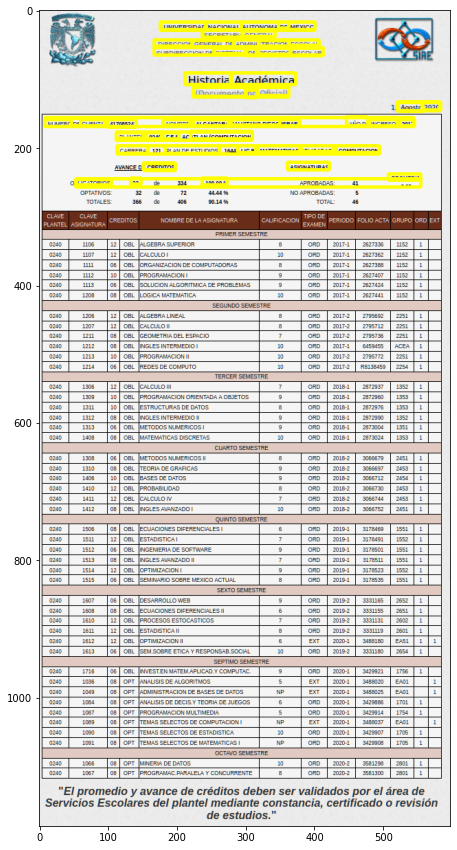

,DetectedText,Type,Confidence
0,UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO,LINE,96.177139
1,SECRETARIA GENERAL,LINE,95.944130
2,DIRECCION GENERAL DE STRACION ESCOLAR,LINE,91.621323
3,SUBDIRECCION DE SISTEMAS,LINE,95.919281
4,DE REGISTRO ESCOLAR,LINE,94.718414
...,...,...,...
59,ASIGNATURAS,WORD,95.610718
60,PROMEDIO,WORD,93.687325
61,BLIGATORIOS:,WORD,89.894585
62,334,WORD,93.456848


In [9]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_text

client_rekognition = boto3.client('rekognition', 'us-east-2')
detect_text = pd.DataFrame(
    client_rekognition.detect_text(
        Image={'Bytes': convert_img_to_bytes(file_path)}
    )['TextDetections']
)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

detect_text[['DetectedText', 'Type', 'Confidence']]

### AWS Textract - Analyze document

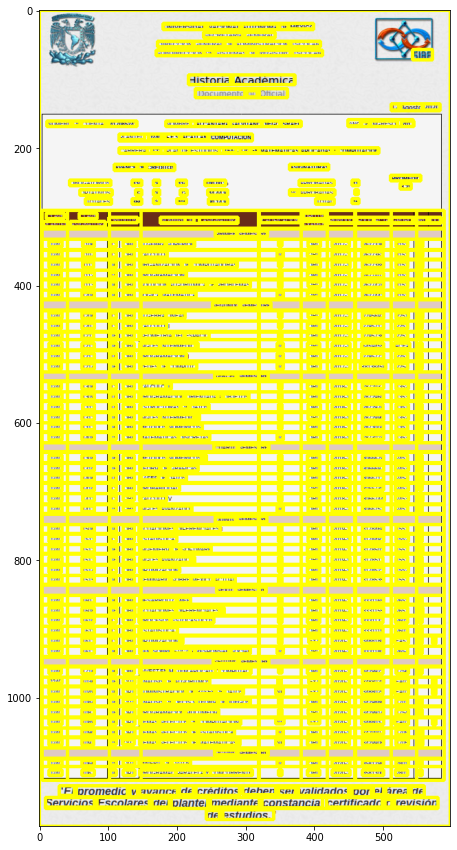

,BlockType,Geometry,Id,Confidence,Text,RowIndex,ColumnIndex,RowSpan,ColumnSpan,Relationship_type,Relationship_ids
0,PAGE,"{'BoundingBox': {'Width': 1.0, 'Height': 1.0, ...",c072f482-9326-418e-a03d-c0d5faa271ff,NaN,NaN,NaN,NaN,NaN,NaN,CHILD,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,LINE,"{'BoundingBox': {'Width': 0.36784881353378296,...",4c7a3e17-bedc-4a47-8eee-bb4d7cb64101,99.654854,UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO,NaN,NaN,NaN,NaN,CHILD,"[567, 568, 569, 570, 571]"
2,LINE,"{'BoundingBox': {'Width': 0.17417177557945251,...",4fbed142-3891-4b88-bb2d-e4f7bcdfeeb9,99.484482,SECRETARIA GENERAL,NaN,NaN,NaN,NaN,CHILD,"[572, 573]"
3,LINE,"{'BoundingBox': {'Width': 0.39691537618637085,...",51ff97d3-0301-444a-92b5-7ec0f0652df9,99.486725,DIRECCION GENERAL DE ADMINISTRACION ESCOLAR,NaN,NaN,NaN,NaN,CHILD,"[574, 575, 576, 577, 578]"
4,LINE,"{'BoundingBox': {'Width': 0.40474918484687805,...",12fad0d2-3331-4ac3-bffd-b40bc28083cf,99.393127,SUBDIRECCION DE SISTEMAS DE REGISTRO ESCOLAR,NaN,NaN,NaN,NaN,CHILD,"[579, 580, 581, 582, 583, 584]"
...,...,...,...,...,...,...,...,...,...,...,...
1838,CELL,"{'BoundingBox': {'Width': 0.0647420734167099, ...",d6e0d1ec-5a8b-4ac8-9d96-e1793371981b,99.999939,NaN,55.0,6.0,1.0,1.0,CHILD,[1263]
1839,CELL,"{'BoundingBox': {'Width': 0.06723227351903915,...",a6a518ac-4470-43ca-80f8-8de8e9c3ff9b,99.999939,NaN,55.0,7.0,1.0,1.0,CHILD,[1264]
1840,CELL,"{'BoundingBox': {'Width': 0.08715295046567917,...",9be799a4-7f19-4afe-bac1-cfd2d95d2212,99.999939,NaN,55.0,8.0,1.0,1.0,CHILD,[1265]
1841,CELL,"{'BoundingBox': {'Width': 0.06225207820534706,...",ff7a6873-262b-4b5e-9cff-75218a339e03,99.999939,NaN,55.0,9.0,1.0,1.0,CHILD,[1266]


In [40]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.analyze_document

client_textract = boto3.client('textract')
analyze_document = pd.DataFrame(
    client_textract.analyze_document(
        Document={'Bytes': convert_img_to_bytes(file_path)},
        FeatureTypes=['TABLES'],
    )['Blocks']
)
analyze_document['Relationship_type'], analyze_document['Relationship_ids'] = get_relationship_type_ids(analyze_document['Id'], analyze_document['Relationships'])
analyze_document.drop('Relationships', axis=1, inplace=True)


img_bounding_boxes = cv2.imread(file_path)
for row in analyze_document.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

analyze_document

### AWS Textract - Detect document text

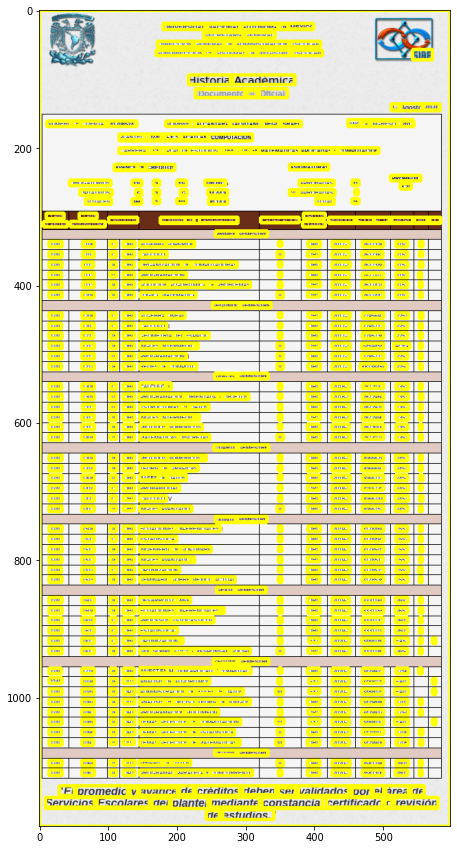

,BlockType,Confidence,Text,Relationship_type,Relationship_ids
0,PAGE,NaN,NaN,CHILD,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,LINE,99.654854,UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO,CHILD,"[567, 568, 569, 570, 571]"
2,LINE,99.484482,SECRETARIA GENERAL,CHILD,"[572, 573]"
3,LINE,99.486725,DIRECCION GENERAL DE ADMINISTRACION ESCOLAR,CHILD,"[574, 575, 576, 577, 578]"
4,LINE,99.393127,SUBDIRECCION DE SISTEMAS DE REGISTRO ESCOLAR,CHILD,"[579, 580, 581, 582, 583, 584]"
...,...,...,...,...,...
1287,WORD,99.983856,certificado,None,None
1288,WORD,97.172943,o,None,None
1289,WORD,99.969360,revision,None,None
1290,WORD,99.304871,de,None,None


In [41]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.detect_document_text

client_textract = boto3.client('textract')
detect_document_text = pd.DataFrame(
    client_textract.detect_document_text(
        Document={'Bytes': convert_img_to_bytes(file_path)},
    )['Blocks']
)
detect_document_text['Relationship_type'], detect_document_text['Relationship_ids'] = get_relationship_type_ids(detect_document_text['Id'], detect_document_text['Relationships'])
detect_document_text.drop('Relationships', axis=1, inplace=True)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_document_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

detect_document_text[['BlockType', 'Confidence', 'Text', 'Relationship_type', 'Relationship_ids']]